In [8]:
from Classes.LoadModel import BaseModel
from Classes.Predict import Prediction
from Classes.Summarize import *
from Classes.Multiclass_model import *
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Layer, Input, Dropout, Activation, Convolution2D, MaxPooling2D
import tensorflow as tf
from tensorflow.keras.layers import (Dense, Conv2D, MaxPool2D, Dropout, Flatten, LeakyReLU, BatchNormalization)

In [2]:
# Start images processing and dataframe splitting
Multi = Multiclass_Model(IND_FILE)
trainer = Train(IND_FILE, IMAGE_PATH)

In [3]:
print('Reading File...')
print(f'Preparing data.. \nCreating Train, Test...')

label_list = ['Brown_Hair','Blond_Hair', 'Black_Hair','Bald', 'Gray_Hair']
train, test = Multi.create_dataframe_multi(label_list, 4500)
print('Done!')

Reading File...
Preparing data.. 
Creating Train, Test...
Assertions Passed! Sets  Are of image files W/O Duplication
Done!


In [4]:
# Split Train, Validation and Test Sets
print(f'\nRunning data generator...')
model_name = 'vgg19'
train_data, valid_data, test_data = Multi.generator_splitter_multi(model_name, train, test, IMAGE_PATH)


Running data generator...
Found 13804 validated image filenames belonging to 5 classes.
Found 3450 validated image filenames belonging to 5 classes.
Found 4494 validated image filenames.


In [5]:
# Loading Base Model
print(f'\n\nLoading Model...')
print('Pick a Model: vgg19, MobileNetV2, vggface, facenet, emotion, age, gender, race')
model_name = 'vgg19'
label_name = 'Hair_color_2'
model_file = os.path.join('Weights/', model_name + '_' + label_name + '.h5')
json_path = os.path.join('json/', model_name + '_' + label_name + '.json')
epoch = 100



Loading Model...
Pick a Model: vgg19, MobileNetV2, vggface, facenet, emotion, age, gender, race


In [6]:
# Training
print(f'\nTraining Start...')
basemodel = BaseModel(model_name)

base_model = basemodel.load_model()
base_model.trainable = False


Training Start...
Input_shape:	(None, 224, 224, 3)
Output_shape:	(None, 7, 7, 512)
Params:	20024384
Layer:	22


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________

In [9]:
# Trainable classification head
model = tf.keras.Sequential(base_model.layers)

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(5, activation = 'softmax'))

history, model = trainer.start_train(model, model_file, train_data, valid_data, epoch, multi=True,
                                     callback=None,
                                     optimize=None)
print('Loading best weights...')
model.load_weights(model_file)
print('Done!')

# Saving History
with open(json_path, 'w') as f:
    json.dump(history.history, f)
history = json.load(open(json_path))

Epoch 1/100
215/215 [==============================] - ETA: 0s - loss: 1.3598 - accuracy: 0.4959
Epoch 00001: val_loss improved from inf to 0.74637, saving model to Weights/vgg19_Hair_color_2.h5
215/215 [==============================] - 105s 487ms/step - loss: 1.3598 - accuracy: 0.4959 - val_loss: 0.7464 - val_accuracy: 0.7164
Epoch 2/100
215/215 [==============================] - ETA: 0s - loss: 0.8974 - accuracy: 0.6588
Epoch 00002: val_loss improved from 0.74637 to 0.61522, saving model to Weights/vgg19_Hair_color_2.h5
215/215 [==============================] - 104s 483ms/step - loss: 0.8974 - accuracy: 0.6588 - val_loss: 0.6152 - val_accuracy: 0.7630
Epoch 3/100
215/215 [==============================] - ETA: 0s - loss: 0.7075 - accuracy: 0.7332
Epoch 00003: val_loss improved from 0.61522 to 0.57188, saving model to Weights/vgg19_Hair_color_2.h5
215/215 [==============================] - 104s 484ms/step - loss: 0.7075 - accuracy: 0.7332 - val_loss: 0.5719 - val_accuracy: 0.7801
Ep

In [10]:
# Evaluate the network on valid data
Prediction.evaluate_model(model, valid_data)

Evaluating the network ...
54/54 [==============================] - 23s 430ms/step - loss: 0.5652 - accuracy: 0.7881
Validation Loss:	0.565
Validation Acc.:	0.788


In [11]:
labels = (train_data.class_indices)
labels

{'Bald': 0, 'Black_Hair': 1, 'Blond_Hair': 2, 'Brown_Hair': 3, 'Gray_Hair': 4}

In [12]:
# Predict on test data
y_pred = Prediction.test_prediction(model, test_data, train_data)

Starting prediction...
Done!


Confusion Matrix ...
     0    1    2    3    4
0  781   23    0    2   92
1   26  714    1  140    9
2    4    7  719  114   55
3    1  137   93  621   44
4  187   13   40   40  617


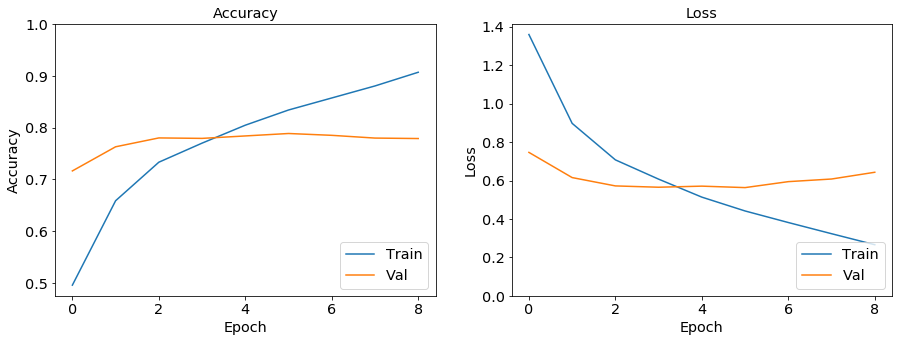

Classification Report ...
{'Bald': {'precision': 0.7817817817817818, 'recall': 0.8697104677060133, 'f1-score': 0.823405376910912, 'support': 898}, 'Black_Hair': {'precision': 0.7986577181208053, 'recall': 0.802247191011236, 'f1-score': 0.8004484304932735, 'support': 890}, 'Blond_Hair': {'precision': 0.8429073856975381, 'recall': 0.7997775305895439, 'f1-score': 0.8207762557077625, 'support': 899}, 'Brown_Hair': {'precision': 0.6772082878953108, 'recall': 0.6930803571428571, 'f1-score': 0.6850523993381137, 'support': 896}, 'Gray_Hair': {'precision': 0.7552019583843329, 'recall': 0.6878483835005574, 'f1-score': 0.7199533255542591, 'support': 897}, 'accuracy': 0.7705357142857143, 'macro avg': {'precision': 0.7711514263759538, 'recall': 0.7705327859900415, 'f1-score': 0.769927157600864, 'support': 4480}, 'weighted avg': {'precision': 0.7711638240032564, 'recall': 0.7705357142857143, 'f1-score': 0.7699330509632615, 'support': 4480}}


In [13]:
# plot
top = min(len(test['label']), len(y_pred))
metrics = Metrics(history, epoch, test['label'][:top].tolist(), y_pred[:top], model_name, label_name)
metrics.confusion_matrix()
metrics.acc_loss_graph()
metrics.classification_report()